# Deutsch-Jozsa Algorithm

In this section, we first introduce the Deutsch-Jozsa problem, and classical and quantum algorithms to solve it. We then implement the quantum algorithm using Qiskit, and run it on a simulator and device.

## Contents

1. [Introduction](#introduction)     
   1.1 [Deutsch-Jozsa Problem](#djproblem)    
   1.2 [Deutsch-Jozsa Algorithm](#classical-solution)    
   1.3 [The Quantum Solution](#quantum-solution)    
   1.4 [Why Does This Work?](#why-does-this-work)     
2. [Worked Example](#example)
3. [Creating Quantum Oracles](#creating-quantum-oracles)     
4. [Qiskit Implementation](#implementation)  
   4.1 [Constant Oracle](#const_oracle)     
   4.2 [Balanced Oracle](#balanced_oracle)  
   4.3 [The Full Algorithm](#full_alg)     
   4.4 [Generalised Circuit](#general_circs)     
5. [Running on Real Devices](#device)    
6. [Problems](#problems)
7. [References](#references)

## 1. Introduction <a id='introduction'></a>

The Deutsch-Jozsa algorithm, first introduced in Reference [1], was the first example of a quantum algorithm that performs better than the best classical algorithm. It showed that there can be advantages to using a quantum computer as a computational tool for a specific problem.

### 1.1 Deutsch-Jozsa Problem <a id='djproblem'> </a>

We are given a hidden Boolean function $f$, which takes as input a string of bits, and returns either $0$ or $1$, that is:

$$
f(\{x_0,x_1,x_2,...\}) \rightarrow 0 \textrm{ or } 1 \textrm{ , where } x_n \textrm{ is } 0 \textrm{ or } 1$$

The property of the given Boolean function is that it is guaranteed to either be balanced or constant. A constant function returns all $0$'s or all $1$'s for any input, while a balanced function returns $0$'s for exactly half of all inputs and $1$'s for the other half. Our task is to determine whether the given function is balanced or constant. 

Note that the Deutsch-Jozsa problem is an $n$-bit extension of the single bit Deutsch problem. 

### 1.2 The Classical Solution <a id='classical-solution'> </a>

Classically, in the best case, two queries to the oracle can determine if the hidden Boolean function, $f(x)$, is balanced: 
e.g. if we get both $f(0,0,0,...)\rightarrow 0$ and $f(1,0,0,...) \rightarrow 1$, then we know the function is balanced as we have obtained the two different outputs.  

In the worst case, if we continue to see the same output for each input we try, we will have to check exactly half of all possible inputs plus one in order to be certain that $f(x)$ is constant. Since the total number of possible inputs is $2^n$, this implies that we need $2^{n-1}+1$ trial inputs to be certain that $f(x)$ is constant in the worst case. For example, for a $4$-bit string, if we checked $8$ out of the $16$ possible combinations, getting all $0$'s, it is still possible that the $9^\textrm{th}$ input returns a $1$ and $f(x)$ is balanced. Probabilistically, this is a very unlikely event. In fact, if we get the same result continually in succession, we can express the probability that the function is constant as a function of $k$ inputs as:



$$ P_\textrm{constant}(k) = 1 - \frac{1}{2^{k-1}} \qquad \textrm{for } k \leq 2^{n-1}$$



Realistically, we could opt to truncate our classical algorithm early, say if we were over x% confident. But if we want to be 100% confident, we would need to check $2^{n-1}+1$ inputs.

### 1.3 Quantum Solution <a id='quantum-solution'> </a>

Using a quantum computer, we can solve this problem with 100% confidence after only one call to the function $f(x)$, provided we have the function $f$ implemented as a quantum oracle, which maps the state $\vert x\rangle \vert y\rangle $ to $ \vert x\rangle \vert y \oplus f(x)\rangle$, where $\oplus$ is addition modulo $2$. Below is the generic circuit for the Deutsh-Jozsa algorithm.

![image1](images/deutsch_steps.png)

Now, let's go through the steps of the algorithm:

<ol>
   <li>
        Prepare two quantum registers. The first is an $n$-qubit register initialised to $|0\rangle$, and the second is a one-qubit register initialised to $|1\rangle$:
        

$$\vert \psi_0 \rangle = \vert0\rangle^{\otimes n} \vert 1\rangle$$


   </li>
    
   <li>
        Apply a Hadamard gate to each qubit:
        

$$\vert \psi_1 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle \left(|0\rangle - |1 \rangle \right)$$


   </li>
   
   <li>
        Apply the quantum oracle $\vert x\rangle \vert y\rangle$ to $\vert x\rangle \vert y \oplus f(x)\rangle$:
        $$
            \begin{aligned}
            \lvert \psi_2 \rangle  
                & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle (\vert f(x)\rangle - \vert 1 \oplus f(x)\rangle) \\  
                & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}|x\rangle ( |0\rangle - |1\rangle ) 
        \end{aligned}
        $$
       
since for each $x,f(x)$ is either $0$ or $1$.
   </li>

   <li>
       At this point the second single qubit register may be ignored. Apply a Hadamard gate to each qubit in the first register:
        $$
        \begin{aligned}
            \lvert \psi_3 \rangle 
                & = \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)}
                    \left[ \sum_{y=0}^{2^n-1}(-1)^{x \cdot y} 
                    \vert y \rangle \right] \\
                & = \frac{1}{2^n}\sum_{y=0}^{2^n-1}
                    \left[ \sum_{x=0}^{2^n-1}(-1)^{f(x)}(-1)^{x \cdot y} \right]
                    \vert y \rangle
        \end{aligned}
        $$
       
where $x \cdot y = x_0y_0 \oplus x_1y_1 \oplus \ldots \oplus x_{n-1}y_{n-1}$ is the sum of the bitwise product.
   </li>

   <li>
       Measure the first register. Notice that the probability of measuring $\vert 0 \rangle ^{\otimes n} = \lvert \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)} \rvert^2$, which evaluates to $1$ if $f(x)$ is constant and $0$ if $f(x)$ is balanced. 
   </li>

</ol>

### 1.4 Why Does This Work? <a id='why-does-this-work'> </a>

- **Constant Oracle**

When the oracle is *constant*, it has no effect (up to a global phase) on the input qubits, and the quantum states before and after querying the oracle are the same. Since the H-gate is its own inverse, in Step 4 we reverse Step 2 to obtain the initial quantum state of $|00\dots 0\rangle$ in the first register.

$$
H^{\otimes n}\begin{bmatrix} 1 \\ 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix} 
= 
\tfrac{1}{\sqrt{2^n}}\begin{bmatrix} 1 \\ 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}
\quad \xrightarrow{\text{after } U_f} \quad
H^{\otimes n}\tfrac{1}{\sqrt{2^n}}\begin{bmatrix} 1 \\ 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}
= 
\begin{bmatrix} 1 \\ 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix} 
$$

- **Balanced Oracle**

After step 2, our input register is an equal superposition of all the states in the computational basis. When the oracle is *balanced*, phase kickback adds a negative phase to exactly half these states:

$$
U_f \tfrac{1}{\sqrt{2^n}}\begin{bmatrix} 1 \\ 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix} 
= 
\tfrac{1}{\sqrt{2^n}}\begin{bmatrix} -1 \\ 1 \\ -1 \\ \vdots \\ 1 \end{bmatrix}
$$


The quantum state after querying the oracle is orthogonal to the quantum state before querying the oracle. Thus, in Step 4, when applying the H-gates, we must end up with a quantum state that is orthogonal to $|00\dots 0\rangle$. This means we should never measure the all-zero state. 


## 2. Worked Example  <a id='example'></a>

Let's go through a specific example for a two bit balanced function: 

<ol>
    <li> The first register of two qubits is initialized to $|00\rangle$ and the second register qubit to $|1\rangle$ 
        
(Note that we are using subscripts 1, 2, and 3 to index the qubits. A subscript of "12" indicates the state of the register containing qubits 1 and 2)
    

$$\lvert \psi_0 \rangle = \lvert 0 0 \rangle_{12} \otimes \lvert 1 \rangle_{3} $$

 
   </li>
    
   <li> Apply Hadamard on all qubits
    

$$\lvert \psi_1 \rangle = \frac{1}{2} \left( \lvert 0 0 \rangle + \lvert 0 1 \rangle + \lvert 1 0 \rangle + \lvert 1 1 \rangle \right)_{12} \otimes \frac{1}{\sqrt{2}} \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{3}  $$

 
   </li>
    
   <li> The oracle function can be implemented as $\text{Q}_f = CX_{13}CX_{23}$, 
       $$
       \begin{align*}
            \lvert \psi_2 \rangle =  \frac{1}{2\sqrt{2}} \left[ \lvert 0 0 \rangle_{12} \otimes \left( \lvert 0 \oplus 0 \oplus 0 \rangle - \lvert 1 \oplus 0 \oplus 0 \rangle \right)_{3} \\
                  + \lvert 0 1 \rangle_{12} \otimes \left( \lvert 0 \oplus 0 \oplus 1 \rangle - \lvert 1 \oplus 0 \oplus 1 \rangle \right)_{3} \\
                  + \lvert 1 0 \rangle_{12} \otimes \left( \lvert 0 \oplus 1 \oplus 0 \rangle - \lvert 1 \oplus 1 \oplus 0 \rangle \right)_{3} \\
                  + \lvert 1 1 \rangle_{12} \otimes \left( \lvert 0 \oplus 1 \oplus 1 \rangle - \lvert 1 \oplus 1 \oplus 1 \rangle \right)_{3} \right]
        \end{align*}
        $$
   </li>
    
   <li>Simplifying this, we get the following: 
       $$
       \begin{aligned}
        \lvert \psi_2 \rangle & = \frac{1}{2\sqrt{2}} \left[ \lvert 0 0 \rangle_{12} \otimes \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{3} - \lvert 0 1 \rangle_{12} \otimes \left( \lvert 0 \rangle - \lvert  1 \rangle \right)_{3} - \lvert 1 0 \rangle_{12} \otimes \left( \lvert 0  \rangle - \lvert 1 \rangle \right)_{3} + \lvert 1 1 \rangle_{12} \otimes \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{3}  \right] \\
        & = \frac{1}{2} \left( \lvert 0 0 \rangle - \lvert 0 1 \rangle - \lvert 1 0 \rangle + \lvert 1 1 \rangle \right)_{12} \otimes \frac{1}{\sqrt{2}} \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{3} \\
        & = \frac{1}{\sqrt{2}} \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{1} \otimes \frac{1}{\sqrt{2}} \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{2} \otimes \frac{1}{\sqrt{2}} \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{3}
        \end{aligned}
        $$
   </li>
    
   <li> Apply Hadamard on the first register
        

$$ \lvert \psi_3\rangle = \lvert 1 \rangle_{1} \otimes \lvert 1 \rangle_{2} \otimes \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{3} $$


   </li>
   
   <li> Measuring the first two qubits will give the non-zero $11$, indicating a balanced function.
   </li>
</ol>

You can try out similar examples using the widget below. Press the buttons to add H-gates and oracles, re-run the cell and/or set `case="constant"` to try out different oracles.

In [1]:
from qiskit_textbook.widgets import dj_widget
dj_widget(size="small", case="balanced")

HTMLMath(value='$$ |00\\rangle = |00\\rangle $$')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xce\x00\x00\x00\xcc\x08\x06\x00\x00\x00;\xd7\x9c…

## 3. Creating Quantum Oracles <a id='creating-quantum-oracles'> </a>

Let's see some different ways we can create a quantum oracle. 

For a constant function, it is simple:

$\qquad$ 1. if f(x) = 0, then apply the $I$ gate to the qubit in register 2.  
$\qquad$ 2. if f(x) = 1, then apply the $X$ gate to the qubit in register 2.

For a balanced function, there are many different circuits we can create. One of the ways we can guarantee our circuit is balanced is by performing a CNOT for each qubit in register 1, with the qubit in register 2 as the target. For example:

![image2](images/deutsch_balanced1.svg)

In the image above, the top three qubits form the input register, and the bottom qubit is the output register. We can see which input states give which output in the table below:

| Input states that output 0 | Input States that output 1 |
|:--------------------------:|:--------------------------:|
|             000            |             001            |
|             011            |             100            |
|             101            |             010            |
|             110            |             111            |


We can change the results while keeping them balanced by wrapping selected controls in X-gates. For example, see the circuit and its results table below:

![other_balanced_circuit](images/deutsch_balanced2.svg)

| Input states that output 0 | Input states that output 1 |
|:--------------------------:|:--------------------------:|
|             001            |             000            |
|             010            |             011            |
|             100            |             101            |
|             111            |             110            |

## 4. Qiskit Implementation <a id='implementation'></a>

We now implement the Deutsch-Jozsa algorithm for the example of a three-bit function, with both constant and balanced oracles. First let's do our imports:

In [2]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

Next, we set the size of the input register for our oracle:

In [3]:
# set the length of the n-bit input string. 
n = 3

### 4.1 Constant Oracle <a id='const_oracle'></a>
Let's start by creating a constant oracle, in this case the input has no effect on the ouput so we just randomly set the output qubit to be 0 or 1:

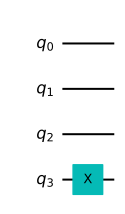

In [4]:
# set the length of the n-bit input string. 
n = 3

const_oracle = QuantumCircuit(n+1)

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)

const_oracle.draw()

### 4.2 Balanced Oracle <a id='balanced_oracle'></a>

In [5]:
balanced_oracle = QuantumCircuit(n+1)

Next, we create a balanced oracle. As we saw in section 1b, we can create a balanced oracle by performing CNOTs with each input qubit as a control and the output bit as the target. We can vary the input states that give 0 or 1 by wrapping some of the controls in X-gates. Let's first choose a binary string of length `n` that dictates which controls to wrap:

In [6]:
b_str = "101"

Now we have this string, we can use it as a key to place our X-gates. For each qubit in our circuit, we place an X-gate if the corresponding digit in `b_str` is `1`, or do nothing if the digit is `0`.

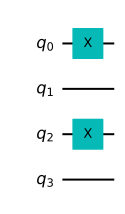

In [7]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)
balanced_oracle.draw()

Next, we do our controlled-NOT gates, using each input qubit as a control, and the output qubit as a target:

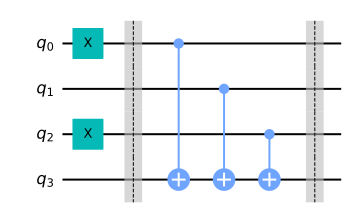

In [8]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()
balanced_oracle.draw()

Finally, we repeat the code from two cells up to finish wrapping the controls in X-gates:

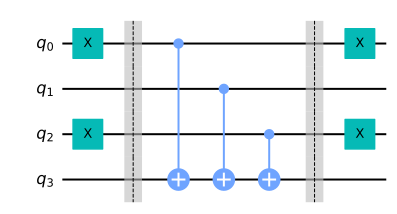

In [9]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Show oracle
balanced_oracle.draw()

We have just created a balanced oracle! All that's left to do is see if the Deutsch-Joza algorithm can solve it.

### 4.3 The Full Algorithm <a id='full_alg'></a>

Let's now put everything together. This first step in the algorithm is to initialise the input qubits in the state $|{+}\rangle$ and the output qubit in the state $|{-}\rangle$:

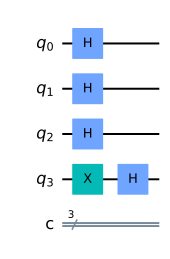

In [10]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)
dj_circuit.draw()

Next, let's apply the oracle. Here we apply the `balanced_oracle` we created above:

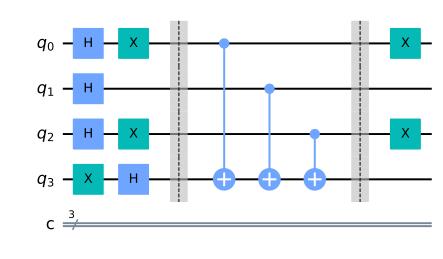

In [11]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit += balanced_oracle
dj_circuit.draw()

Finally, we perform H-gates on the $n$-input qubits, and measure our input register:

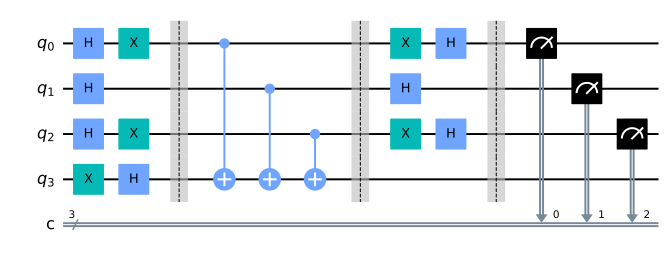

In [12]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit += balanced_oracle

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw()

Let's see the output:

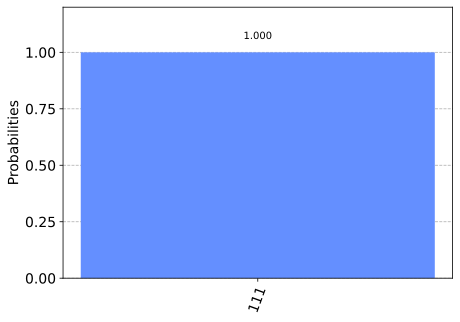

In [13]:
# use local simulator
qasm_sim = Aer.get_backend('qasm_simulator')
shots = 1024
qobj = assemble(dj_circuit, qasm_sim)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

We can see from the results above that we have a 0% chance of measuring `000`. This correctly predicts the function is balanced. 

### 4.4 Generalised Circuits <a id='general_circs'></a>

Below, we provide a generalised function that creates Deutsch-Joza oracles and turns them into quantum gates. It takes the `case`, (either `'balanced'` or '`constant`', and `n`, the size of the input register:

In [14]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

Let's also create a function that takes this oracle gate and performs the Deutsch-Joza algorithm on it:

In [15]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

Finally, let's use these functions to play around with the algorithm:

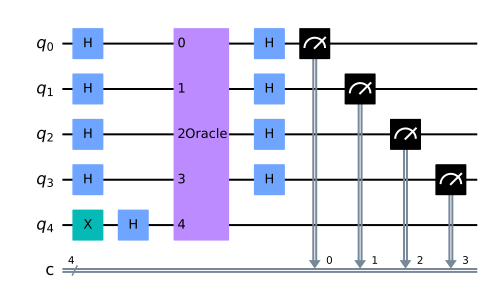

In [16]:
n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()

And see the results of running this circuit:

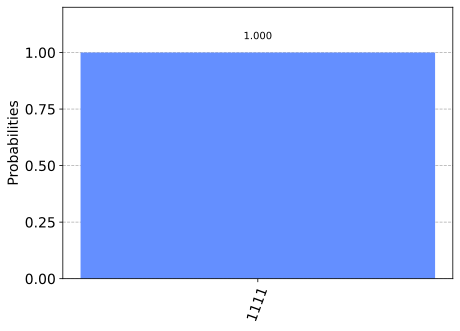

In [17]:
transpiled_dj_circuit = transpile(dj_circuit, qasm_sim)
qobj = assemble(transpiled_dj_circuit)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

## 5. Experiment with Real Devices <a id='device'></a>

We can run the circuit on the real device as shown below. We first look for the least-busy device that can handle our circuit.

In [18]:
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

/usr/local/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


least busy backend:  ibmq_montreal


In [19]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
transpiled_dj_circuit = transpile(dj_circuit, backend, optimization_level=3)
qobj = assemble(transpiled_dj_circuit, backend)
job = backend.run(qobj)
job_monitor(job, interval=2)

Job Status: job has successfully run


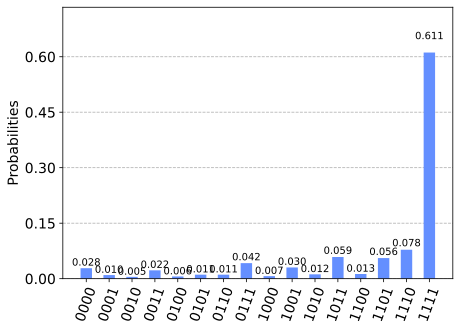

In [20]:
# Get the results of the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

As we can see, the most likely result is `1111`. The other results are due to errors in the quantum computation. 

## 6. Problems <a id='problems'></a>

1. Are you able to create a balanced or constant oracle of a different form?

2. The function `dj_problem_oracle` (below) returns a Deutsch-Joza oracle for `n = 4` in the form of a gate. The gate takes 5 qubits as input where the final qubit (`q_4`) is the output qubit (as with the example oracles above). You can get different oracles by giving `dj_problem_oracle` different integers between 1 and 5. Use the Deutsch-Joza algorithm to decide whether each oracle is balanced or constant (**Note:** It is highly recommended you try this example using the `qasm_simulator` instead of a real device).

In [21]:
from qiskit_textbook.problems import dj_problem_oracle
oracle = dj_problem_oracle(1)

## 7. References <a id='references'></a>

1. David Deutsch and Richard Jozsa (1992). "Rapid solutions of problems by quantum computation". Proceedings of the Royal Society of London A. 439: 553–558.  [doi:10.1098/rspa.1992.0167](https://doi.org/10.1098%2Frspa.1992.0167).
2. R. Cleve; A. Ekert; C. Macchiavello; M. Mosca (1998). "Quantum algorithms revisited". Proceedings of the Royal Society of London A. 454: 339–354. [doi:10.1098/rspa.1998.0164](https://doi.org/10.1098%2Frspa.1998.0164).

In [22]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.2',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.2'}